In [1]:
import sys
sys.path.insert(1, '/t0-analysis/CKA-similarity')

import numpy as np
from CKA import CKA

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0"
module = "encoder"
task = "wic"

In [3]:
# assertions
assert model == "bigscience-T0"
assert module == "encoder"
assert task == "wic"

## Prompts

In [4]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_without_targets,{sentence1} {sentence2} Question: Is the word ...,instructive,False,"▁No, ▁no, ▁Yes, ▁yes","0, 0, 1, 1",False
1,gpt_3_yes_no_with_targets,{sentence1} {sentence2} Question: Is the word ...,instructive,True,"▁No, ▁Yes","0, 1",False
2,affirmation_with_targets,Sentence A: {sentence1} Sentence B: {sentence2...,instructive,True,"▁Fal, ▁True","0, 1",False
3,grammar_homework_with_targets,"Decide whether the word ""{word}"" is used with ...",instructive,True,"▁No, ▁Yes","0, 1",False
4,polysemous_with_targets,"The word ""{word}"" has multiple meanings. Does ...",instructive,True,"▁No, ▁Yes","0, 1",False
5,question_context_without_targets,"Determine if the word ""{word}"" is used in the ...",instructive,False,"▁No, ▁no, ▁Yes, ▁yes","0, 0, 1, 1",False
6,question_meaning_without_targets,"Determine if the word ""{word}"" have the same m...",instructive,False,"▁No, ▁no, ▁Yes, ▁yes","0, 0, 1, 1",False
7,question_meaning_yes_no_with_targets,"Does the word ""{word}"" have the same meanining...",instructive,True,"▁No, ▁Yes","0, 1",False
8,same_sense_with_targets,Sentence 1: {sentence1} Sentence 2: {sentence2...,instructive,True,"▁No, ▁Yes","0, 1",False
9,similar_sense_without_targets,{sentence1} {sentence2} Similar sense of {word}?,instructive,False,"▁No, ▁no, ▁Yes, ▁yes","0, 0, 1, 1",False


## Comput CKA per prompt across layers

In [5]:
use_pattern = [
    "gpt_3_without_targets",
    "gpt_3_yes_no_with_targets",
    "affirmation_with_targets",
    "grammar_homework_with_targets",
    "polysemous_with_targets",
    "question_context_without_targets",
    "question_meaning_without_targets",
    "question_meaning_yes_no_with_targets",
    "same_sense_with_targets",
    "similar_sense_without_targets",
    "similar_sense_yes_no_with_targets",
    "gpt_3_true_false_with_targets",
    "gpt_3_cat_dog_with_targets",
]

In [6]:
representations = {}

for _, row in df.iterrows():
    prompt_name = row['name']
    
    if prompt_name in use_pattern:
        if prompt_name not in representations:
            representations[prompt_name] = {}
        
        for layer in range(0, 25):
            layer_key = f"{module}-{layer}"

            if layer_key not in representations[prompt_name]:
                representations[prompt_name][layer_key] = {}

            file_name = f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5"
            
            # load hidden representations from hdf5 file
            representations[prompt_name][layer_key] = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)

In [7]:
representations.keys()

dict_keys(['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'affirmation_with_targets', 'grammar_homework_with_targets', 'polysemous_with_targets', 'question_context_without_targets', 'question_meaning_without_targets', 'question_meaning_yes_no_with_targets', 'same_sense_with_targets', 'similar_sense_without_targets', 'similar_sense_yes_no_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets'])

In [8]:
# Compute CKA for every pattern across layers
np_cka = CKA()

cka_scores_pattern = {}
for pattern in list(representations.keys())[:]:
    cka_scores = []
    for layer1 in representations[pattern].keys():
        cka_scores_layer1 = []
        for layer2 in representations[pattern].keys():
            cka_score = np_cka.linear_CKA(representations[pattern][layer1], representations[pattern][layer2])
            cka_scores_layer1.append(cka_score)
        cka_scores.append(cka_scores_layer1)
    cka_scores = np.asarray(cka_scores)
    cka_scores_pattern[pattern] = cka_scores

In [9]:
cka_scores_pattern['gpt_3_yes_no_with_targets'].shape

(25, 25)

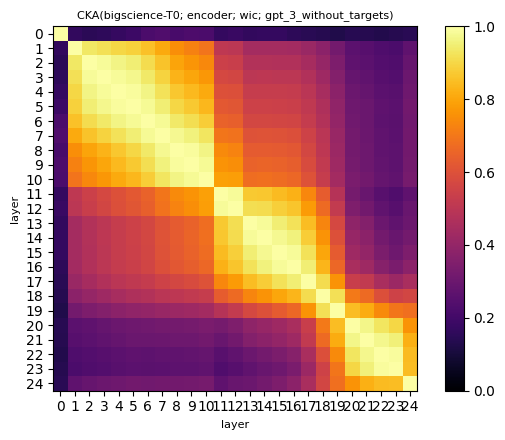

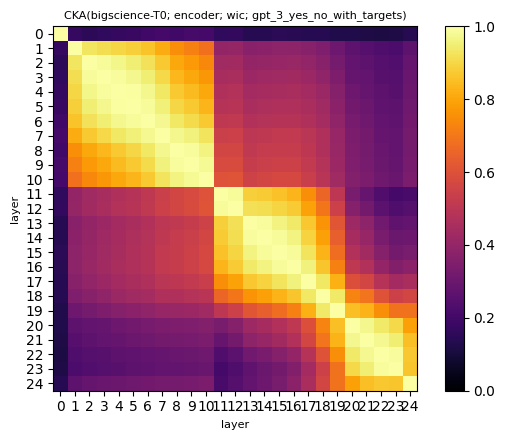

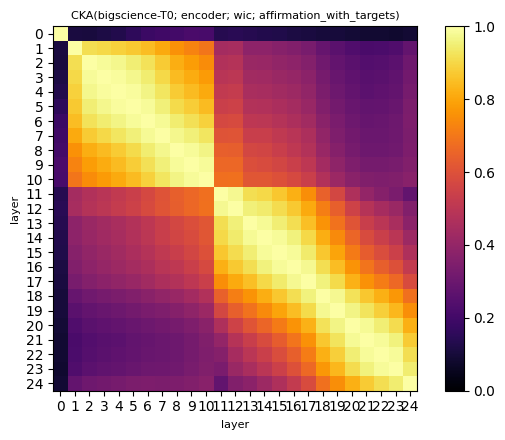

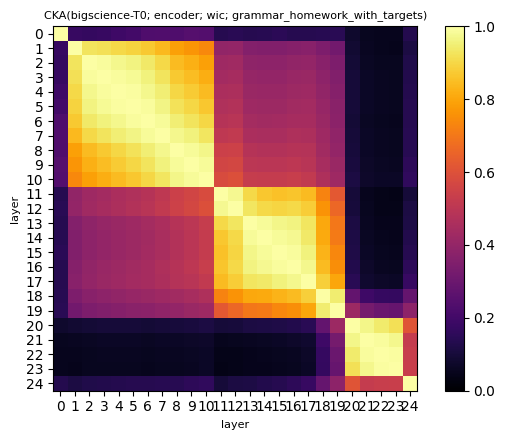

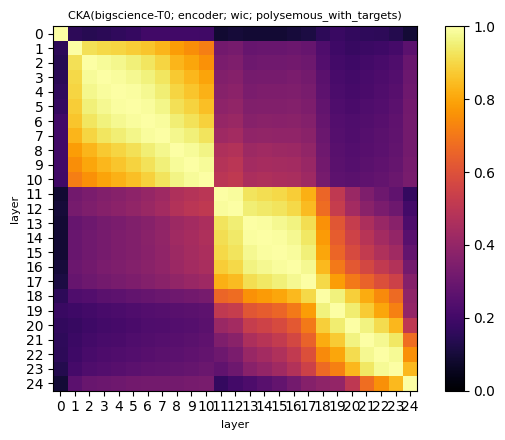

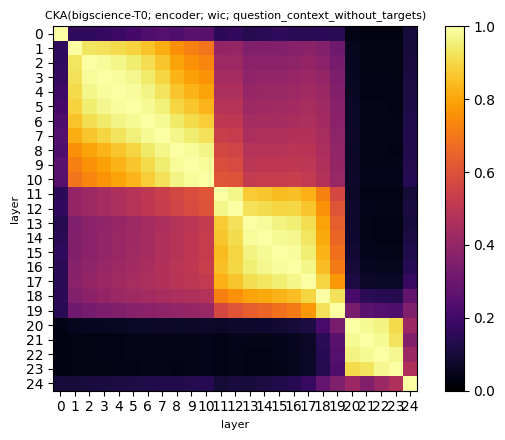

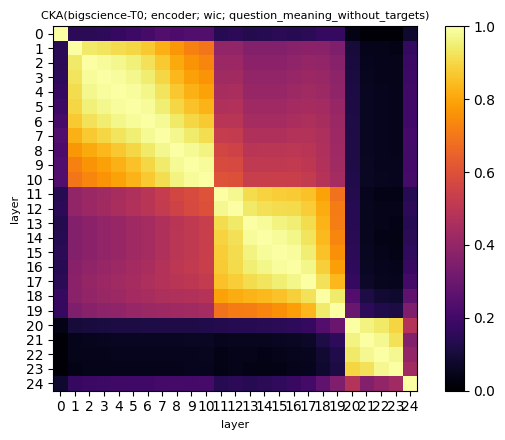

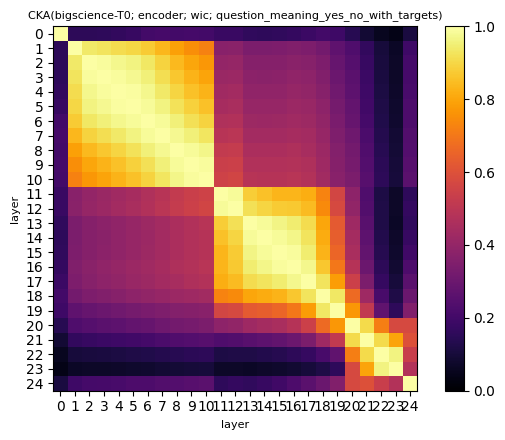

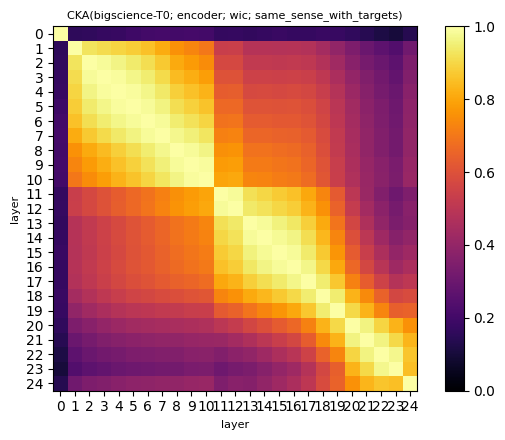

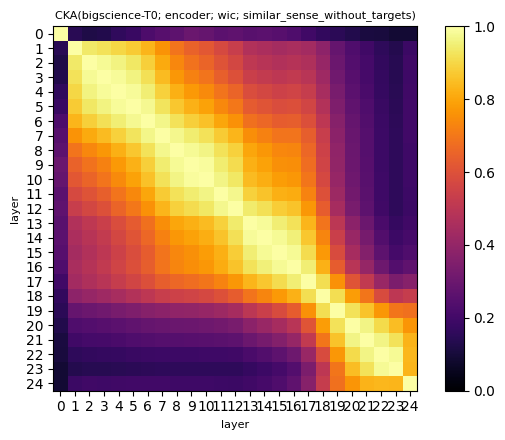

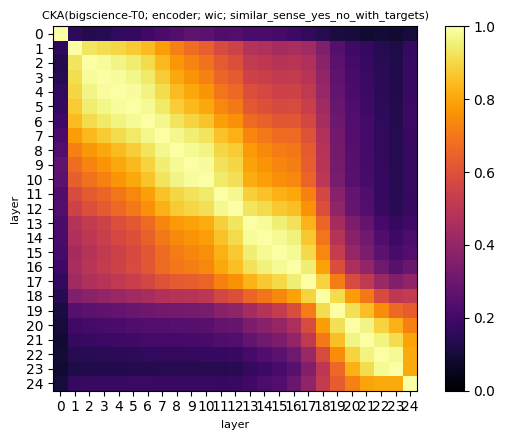

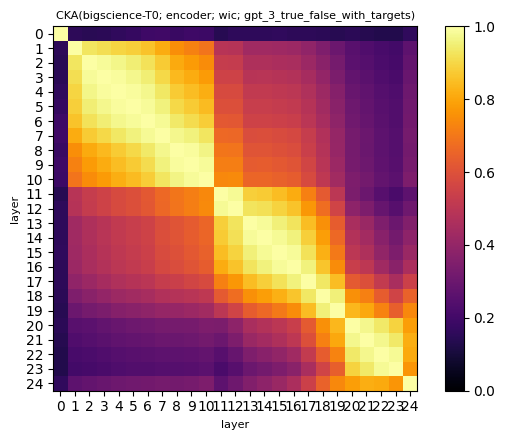

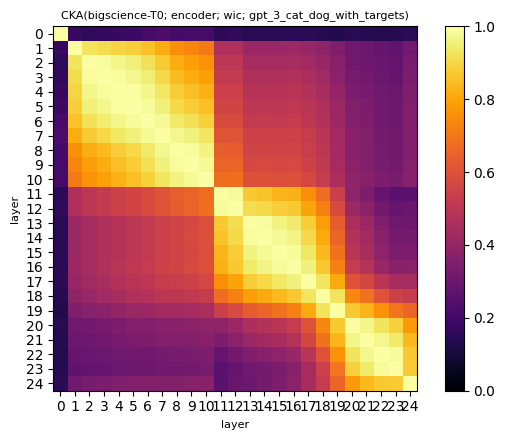

In [10]:
for pattern in list(cka_scores_pattern.keys())[:]:
    values = cka_scores_pattern[pattern]

    fig, axes = plt.subplots(1, 1, figsize=(6.0,4.5), dpi=100)

    im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
    # Create colorbar
    cbar = axes.figure.colorbar(im, ax=axes)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("layer", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("layer", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    axes.set_title(f"CKA({model}; {module}; {task}; {pattern})", fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.close();


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


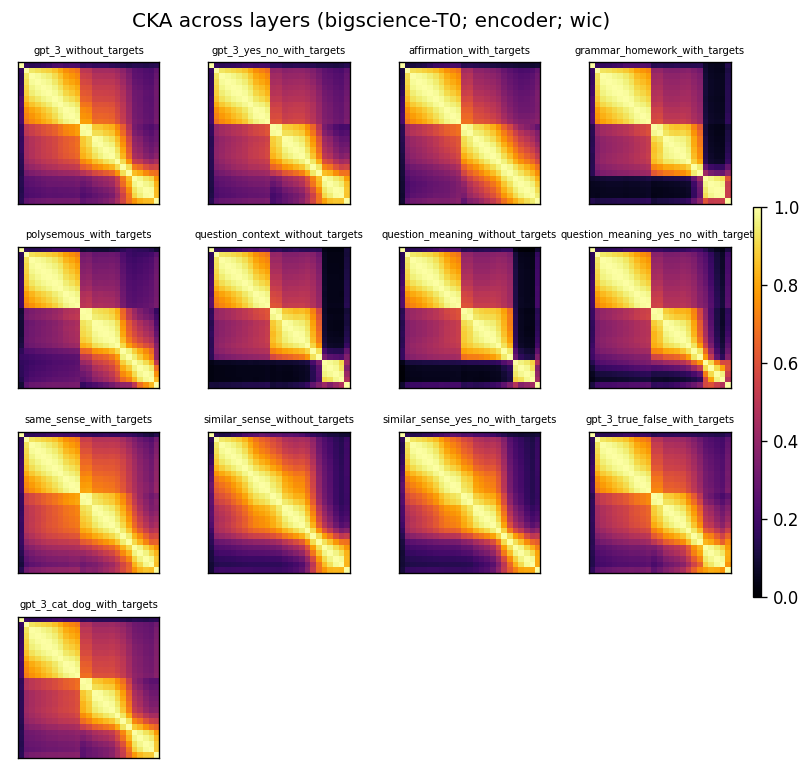

In [11]:
plt.figure(figsize=(6.5, 6.5), dpi=120)

for l, pattern in enumerate(cka_scores_pattern.keys()):
    values = cka_scores_pattern[pattern]

    plt.subplot(4, 4, l+1)
    axes = plt.gca()
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    im = axes.imshow(values, cmap='inferno', vmin=0.0, vmax=1.0)
    # Create colorbar
    # cbar = axes.figure.colorbar(im, ax=axes)
    # cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    axes.set_xlabel("template", fontsize=8)
    axes.set_xticks(np.arange(len(values)))
    axes.set_ylabel("template", fontsize=8)
    axes.set_yticks(np.arange(len(values)))

    # axes.set_title(f"Pairwise CKA ({model}; {module}; {task}; layer={layer})", fontsize=8)
    axes.set_title(f"{pattern}", fontsize=6)

# add colorbar
fig = plt.gcf()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.23, 0.01, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle(f"CKA across layers ({model}; {module}; {task})")
plt.tight_layout(h_pad=2.0)
plt.show()
plt.close();